In [45]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import zeros
from numpy import ones
from numpy.random import randint

import re

import json

import pandas as pd
from pandas import json_normalize

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

from matplotlib import pyplot

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [46]:
def loadData(path):
    with open(path,'r') as handle:
        text_data = handle.read()
        json_data = json.loads(text_data)
        df = pd.DataFrame(json_data)
    return df


#Adding frame numbers for time series plots
def LabelFrame(data):   
    df = pd.DataFrame(data)
    for i in range(len(df.ObjectList.index)):
        for j in df['ObjectList'][i]:
            j['Frame'] = i
            
    df.to_json('temp.json',orient = 'records')
    with open('temp.json') as file:
        data2 = file.read()
        jasondata = json.loads(data2)
    return jasondata


def openfile(path):
    with open(path, 'r') as handle:
        text_data = handle.read()
        text_data = '[' + re.sub(r'\}\s\{','},{', text_data) + ']'
        json_data = json.loads(text_data)
        json_data = LabelFrame(json_data)
    return json_data


#Seperating pk array values into columns
def mergedframe1(df_1):
        frames = [df_1]
        df_merged = pd.concat(frames,ignore_index = True)
        df_classify = pd.DataFrame()
        df_classify[['ObjType','pkArray','dpplIdx']] = df_merged[['ObjType','pkArray','dpplIdx']]
        
        df_classify['pkArray'] = df_classify['pkArray'].apply(lambda pkarray:np.ravel(np.transpose(pkarray)))
        
        all_list = []

        for i in range(35):
            for j in range(len(df_classify.index)):
                all_list.append(df_classify.pkArray[j][i])
        chunk = [all_list[i:i+len(df_classify.index)] for i in range(0, len(all_list), len(df_classify.index))]
        df_classify1 = pd.DataFrame(chunk)
        dfclassify=df_classify1.transpose()
        dfclassify['ObjType'] = df_classify['ObjType']
        dfclassify['rangeIdx'] = df_merged['rangeIdx']
        dfclassify['dpplIdx'] = df_merged['dpplIdx']
        dfclassify['pkArray'] = df_merged['pkArray']
        dfclassify['Range'] = df_merged['Range']
        dfclassify['Coordinates.X'] = df_merged['Coordinates.X']
        dfclassify['Coordinates.Y'] = df_merged['Coordinates.Y']
        dfclassify["pkValue1.Real"] = df_merged["pkValue1.Real"]
        dfclassify["pkValue1.Imaginary"] = df_merged['pkValue1.Imaginary']
        dfclassify["pkValue2.Real"] = df_merged["pkValue2.Real"]
        dfclassify["pkValue2.Imaginary"] = df_merged['pkValue2.Imaginary']
        dfclassify["pkValue3.Real"] = df_merged["pkValue3.Real"]
        dfclassify["pkValue3.Imaginary"] = df_merged['pkValue3.Imaginary']
        dfclassify["pkValue4.Real"] = df_merged["pkValue4.Real"]
        dfclassify["pkValue4.Imaginary"] = df_merged['pkValue4.Imaginary']
        
        dfclassify['Frame'] = df_merged['Frame']
        dfclassify['Range'] = df_merged['Range']
        return dfclassify


# Load all files from json to a dataframe after 
def startdf(json_data,Label):
    df_1= pd.DataFrame()
    df1 = pd.DataFrame((json_data))
    for j in range(len(df1.index)):
        df2 = json_normalize(df1['ObjectList'][j])
        df2['ObjType'] = df2['ObjType'].map(lambda ObjType: Label)        
        #df2 = df2[df2.Range <= UIdx]
        #df2 = df2[df2.Range >= LIdx]
        #df2 = df2[df2.dpplIdx == 1]   
        df_1 = pd.concat([df2,df_1],ignore_index =True)
    df_1 = df_1.sort_values(by=['Frame'],ascending = True)
    df_1 = df_1.reset_index(drop=True)
    df_1['pkArray'] = df_1['pkArray'].map(lambda x:np.transpose(x))
    df_final = mergedframe1(df_1)
    return df_final


def labelData(df, x1, x2, y1, y2, label):
    df['ObjType'] = df['ObjType'].map(lambda x : 0)

    for index, row in df.iterrows():
        if ((row['Coordinates.X'] > x1) & (row['Coordinates.X'] < x2) 
        & (row['Coordinates.Y'] > y1) & (row['Coordinates.Y'] < y2)):
            df.at[index, 'ObjType'] = label
        else:
            df.at[index, 'ObjType'] = 0
    return df


# Shuffle two arrays in unison
def unison_shuffled_copies(array1, array2):
    assert len(array1) == len(array2)
    p = np.random.permutation(len(array1))
    return array1[p], array2[p]


def padHumanRows(df):
  for ind, row in df.iterrows():
    if ((ind % 10) == 0):
      count = 0
      while ((count < 10) and (df.iloc[ind + count]['Frame'] == int(ind/10))):
        count = count + 1
        if ((ind + count) == len(df.index)):
          break
      while (count < 10):
        row = pd.DataFrame({"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "11": 0, "12": 0, "13": 0, "14": 0, "15": 0, "16": 0, "17": 0, "18": 0, "19": 0, "20": 0, "21": 0, "22": 0, "23": 0, "24": 0, "25": 0, "26": 0, "27": 0, "28": 0, "29": 0, "30": 0, "31": 0, "32": 0, "33": 0, "34": 0, "rangeIdx":0, "dpplIdx":0, "Frame": ind/10, "ObjType":0}, index=[ind+count-1+0.5])
        df = df.append(row, ignore_index=False)
        df = df.sort_index().reset_index(drop=True)
        df = df.reindex(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "rangeIdx", "dpplIdx", "Frame", "ObjType"], axis=1)
        count = count + 1
  return df

def padCarRows(df):
  for ind, row in df.iterrows():
    if ((ind % 10) == 0):
      count = 0
      while ((count < 10) and (df.iloc[ind + count]['Frame'] == int(ind/10))):
        count = count + 1
        if ((ind + count) == len(df.index)):
          break
      while (count < 10):
        row = pd.DataFrame({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, "rangeIdx":0, "dpplIdx":0, "Frame": ind/10, "ObjType":0}, index=[ind+count-1+0.5])
        df = df.append(row, ignore_index=False)
        df = df.sort_index().reset_index(drop=True)
        df = df.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, "rangeIdx", "dpplIdx", "Frame", "ObjType"], axis=1)
        count = count + 1
  return df


def padRows(df, obj):
  if (obj == "car"):
    while (df.shape[0] != ((df['Frame'].max() + 1)*10)):
      df = padCarRows(df)
  else:
    while (df.shape[0] != ((df['Frame'].max() + 1)*10)):
      df = padHumanRows(df)  
  return df


def truncateColumns(df):
  df = df.drop(['Range', 'pkArray', 'Coordinates.X', 'Coordinates.Y', 'pkValue1.Real', 
           'pkValue1.Imaginary', 'pkValue2.Real', 'pkValue2.Imaginary', 
           'pkValue3.Real', 'pkValue3.Imaginary', 'pkValue4.Real', 
           'pkValue4.Imaginary', 'ObjType'], axis=1)
  return df


def dfTo2DArray(df):
  df = df[df.columns[0:38]].values
  return df

#to correct the dppl idx
def correctDpplIdx(x):
    if x <=31:
        return x
    if x>31:
        return x-64


# frameTo128x64() function converts a 2D input array
# where rows == objects in json file and cols == 0,1,..34 peak array elements, rangeIdx, dopplIdx, Frame.
# The 2D array is converted to 3D array of size no. of frames * 128 * 64

def frameTo128x64(arr):
    count = 0
    new3DArray = np.empty((1, 128, 64))
    newLabelArr = np.empty((1, 128, 64))
    arr128x64 = np.zeros((128, 64))
    labelArr = np.zeros((128, 64))
    for row in range(0, np.shape(arr)[0], 1):
        if count<=10:
            rangeIndex = int(arr[row][35])
            dopplerIndex = int(correctDpplIdx(arr[row][36]))
            label = arr[row][37]
            r = 0
            
            for rangeID in range(rangeIndex-3, rangeIndex+4, 1):
                d = 0
                for dopplID in range(dopplerIndex-2, dopplerIndex+3, 1):
                    if ((0 <= rangeID <= 127) and (-32 <= dopplID <= 31)):
                        if(arr128x64[rangeID][dopplID+32] < arr[row][(d * 7) + r]):
                            arr128x64[rangeID][dopplID+32] = arr[row][(d * 7) + r]
                        if(labelArr[rangeID][dopplID+32] == 0):
                            labelArr[rangeID][dopplID+32] = label
                    d = d + 1
                r = r + 1
        count= count + 1
        if count == 10:
            count = 0
            arr128x64 = np.reshape(arr128x64, (1, 128, 64))
            labelArr = np.reshape(labelArr, (1, 128, 64))
            new3DArray = np.append(new3DArray, arr128x64, axis=0)
            newLabelArr = np.append(newLabelArr, labelArr, axis=0)
            arr128x64 = np.zeros((128, 64))
            labelArr = np.zeros((128, 64))
    return new3DArray[1:, :, :], newLabelArr[1:, :, :]

In [47]:
humanDay1_9pm = loadData("../RadarDataset/human/human_9pm.json")
carVday1_10 = startdf(openfile("../RadarDataset/carV/Car Vertical_10_27_01_2020 12_46_59.json"), 2)
carVday1_19 = startdf(openfile("../RadarDataset/carV/Car Vertical_19_27_01_2020 12_57_35.json"), 2)
carHday1_11 = startdf(openfile("../RadarDataset/carH/Car Horizontal_11_27_01_2020 13_40_38.json"), 3)
carHday1_20 = startdf(openfile("../RadarDataset/carH/Car Horizontal_20_27_01_2020 13_21_11.json"), 3)

In [48]:
arrHumanDay1_9pm, labelHumanDay1_9pm = frameTo128x64(dfTo2DArray(padRows(labelData(humanDay1_9pm, -0.5, 0.5, 0.1, 7.9, 1), "human")))
arrCarVday1_10, labelCarVday1_10 = frameTo128x64(dfTo2DArray(padRows(labelData(carVday1_10, -1.5, 1.5, 9.5, 11.5, 2), "car")))
arrCarVday1_19, labelCarVday1_19 = frameTo128x64(dfTo2DArray(padRows(labelData(carVday1_19, -1.5, 1.5, 18.5, 20.5, 2), "car")))
arrCarHday1_11, labelCarHday1_11 = frameTo128x64(dfTo2DArray(padRows(labelData(carHday1_11, -3, 3, 10.5, 13, 3), "car")))
arrCarHday1_20, labelCarHday1_20 = frameTo128x64(dfTo2DArray(padRows(labelData(carHday1_20, -3, 3, 19.5, 22, 3), "car")))

In [49]:
arrHumanDay1_9pm = np.reshape(arrHumanDay1_9pm, (arrHumanDay1_9pm.shape[0], 128, 64, 1))
arrCarVday1_10 = np.reshape(arrCarVday1_10, (arrCarVday1_10.shape[0], 128, 64, 1))
arrCarVday1_19 = np.reshape(arrCarVday1_19, (arrCarVday1_19.shape[0], 128, 64, 1))
arrCarHday1_11 = np.reshape(arrCarHday1_11, (arrCarHday1_11.shape[0], 128, 64, 1))
arrCarHday1_20 = np.reshape(arrCarHday1_20, (arrCarHday1_20.shape[0], 128, 64, 1))
labelHumanDay1_9pm = np.reshape(labelHumanDay1_9pm, (labelHumanDay1_9pm.shape[0], 128, 64, 1))
labelCarVday1_10 = np.reshape(labelCarVday1_10, (labelCarVday1_10.shape[0], 128, 64, 1))
labelCarVday1_19 = np.reshape(labelCarVday1_19, (labelCarVday1_19.shape[0], 128, 64, 1))
labelCarHday1_11 = np.reshape(labelCarHday1_11, (labelCarHday1_11.shape[0], 128, 64, 1))
labelCarHday1_20 = np.reshape(labelCarHday1_20, (labelCarHday1_20.shape[0], 128, 64, 1))

In [50]:
# plot arrays/images in dataset

def plotArrays(src, target, title):
    n_samples = 5

    src_images, tar_images = src, target

    pyplot.figure(figsize=(50, 20))

    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis([0, 64, 0, 128])
        pyplot.xlabel("doppler index")
        pyplot.ylabel("range index(res=0.5m)")
        pyplot.title(title)
        pyplot.imshow(src_images[i+100].astype('uint8'))

    # plot target image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis([0, 64, 0, 128])
        pyplot.xlabel("doppler index")
        pyplot.ylabel("range index(res=0.5m)")
        pyplot.title(title)
        pyplot.imshow(tar_images[i+100].astype('uint8'))
        
    pyplot.show()

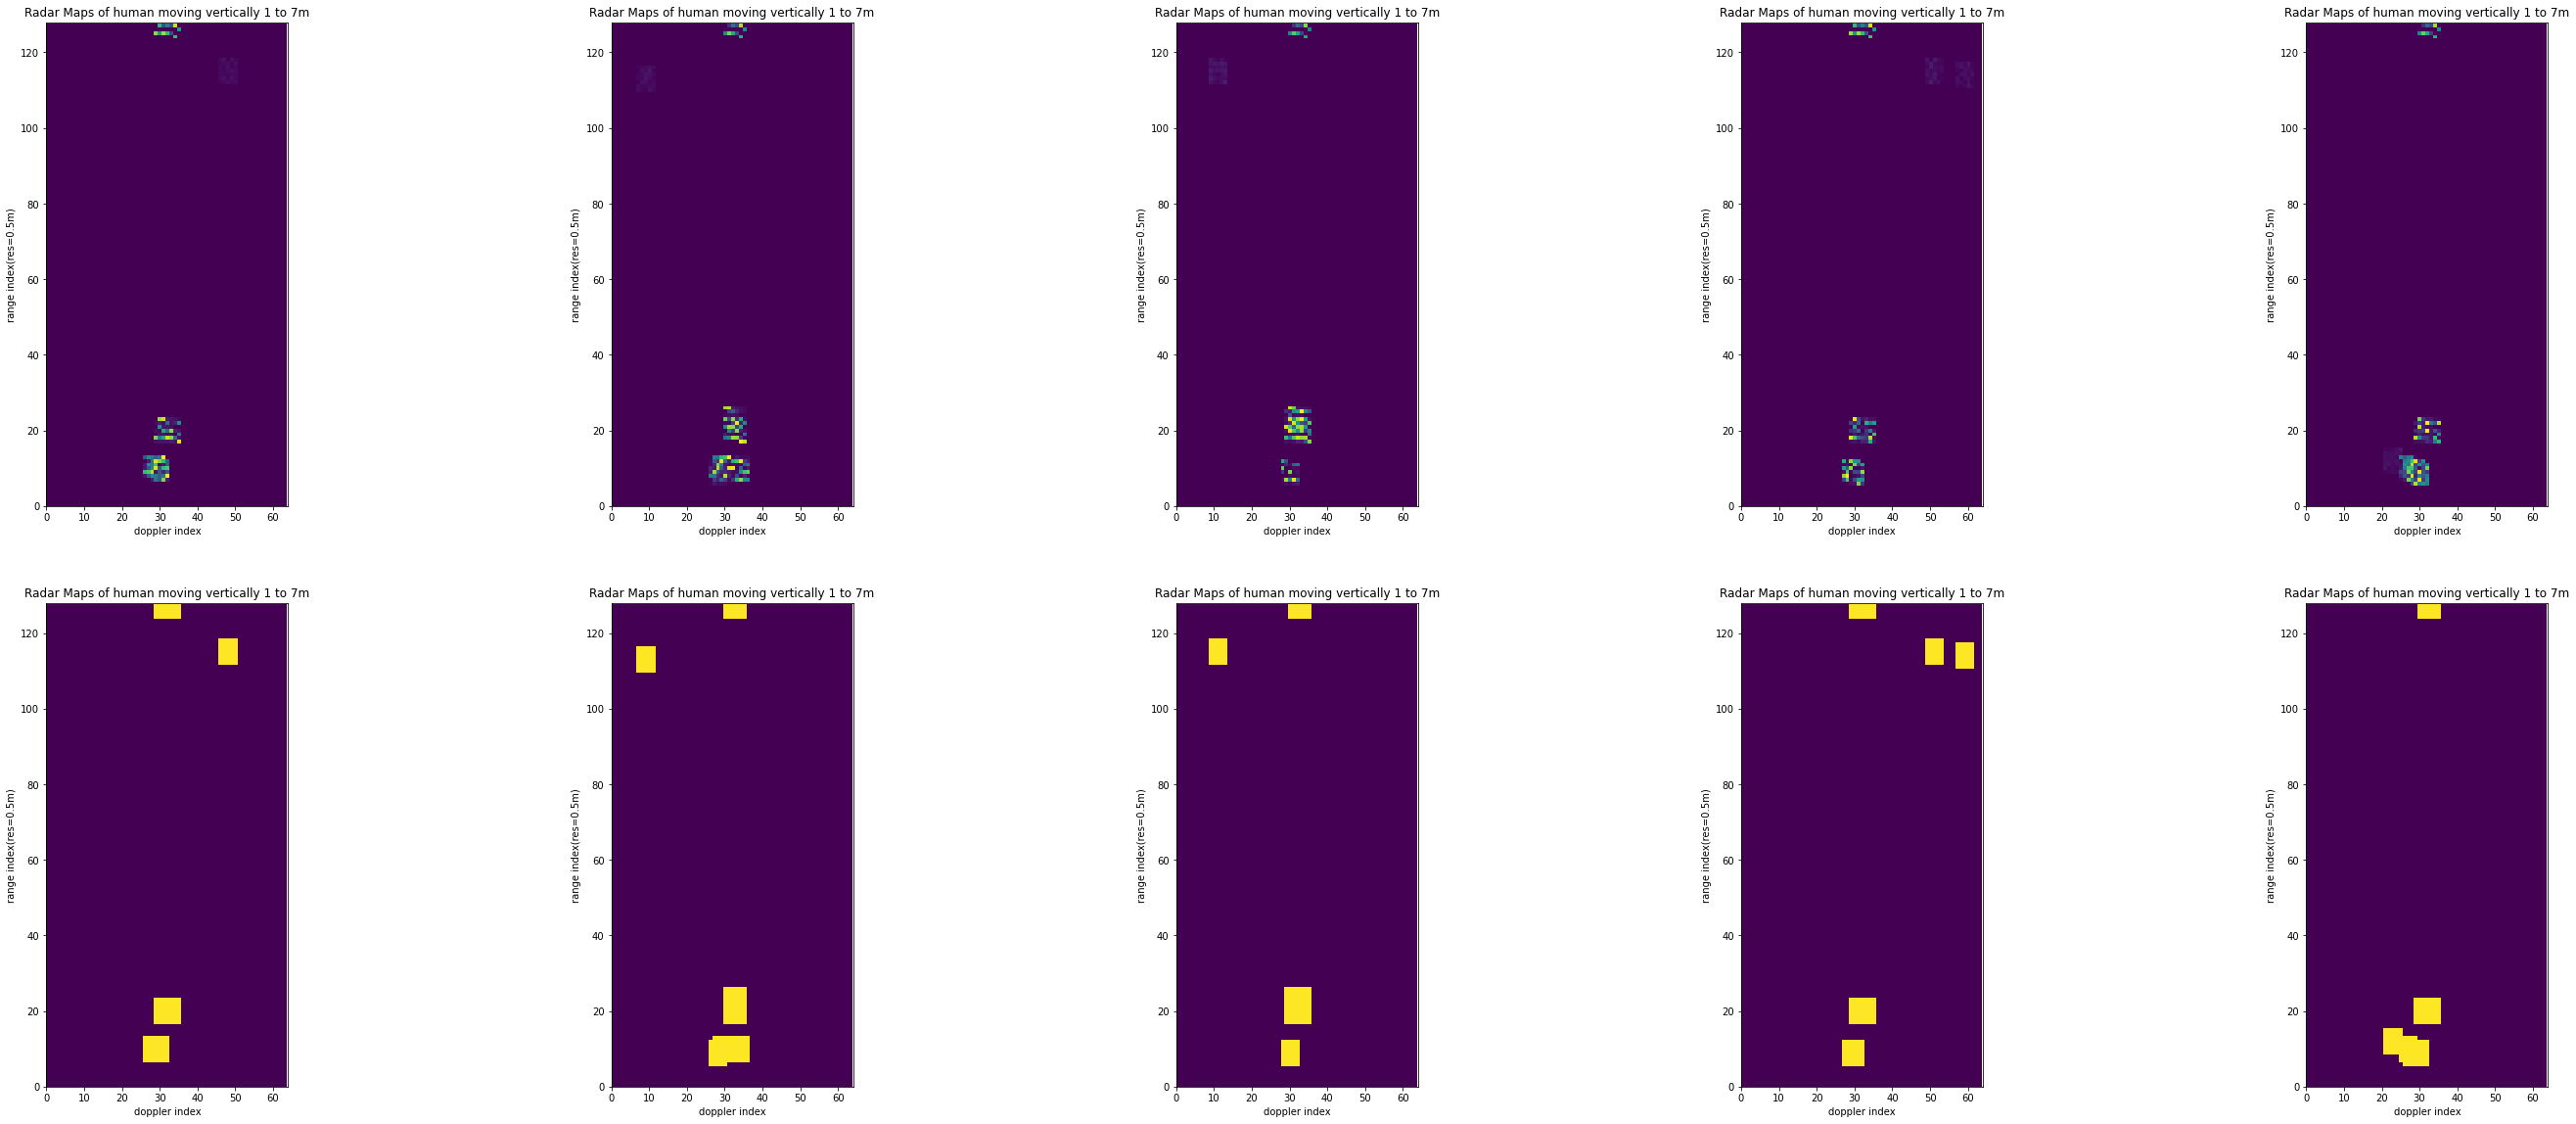

In [51]:
plotArrays(arrHumanDay1_9pm, labelHumanDay1_9pm, "Radar Maps of human moving vertically 1 to 7m")

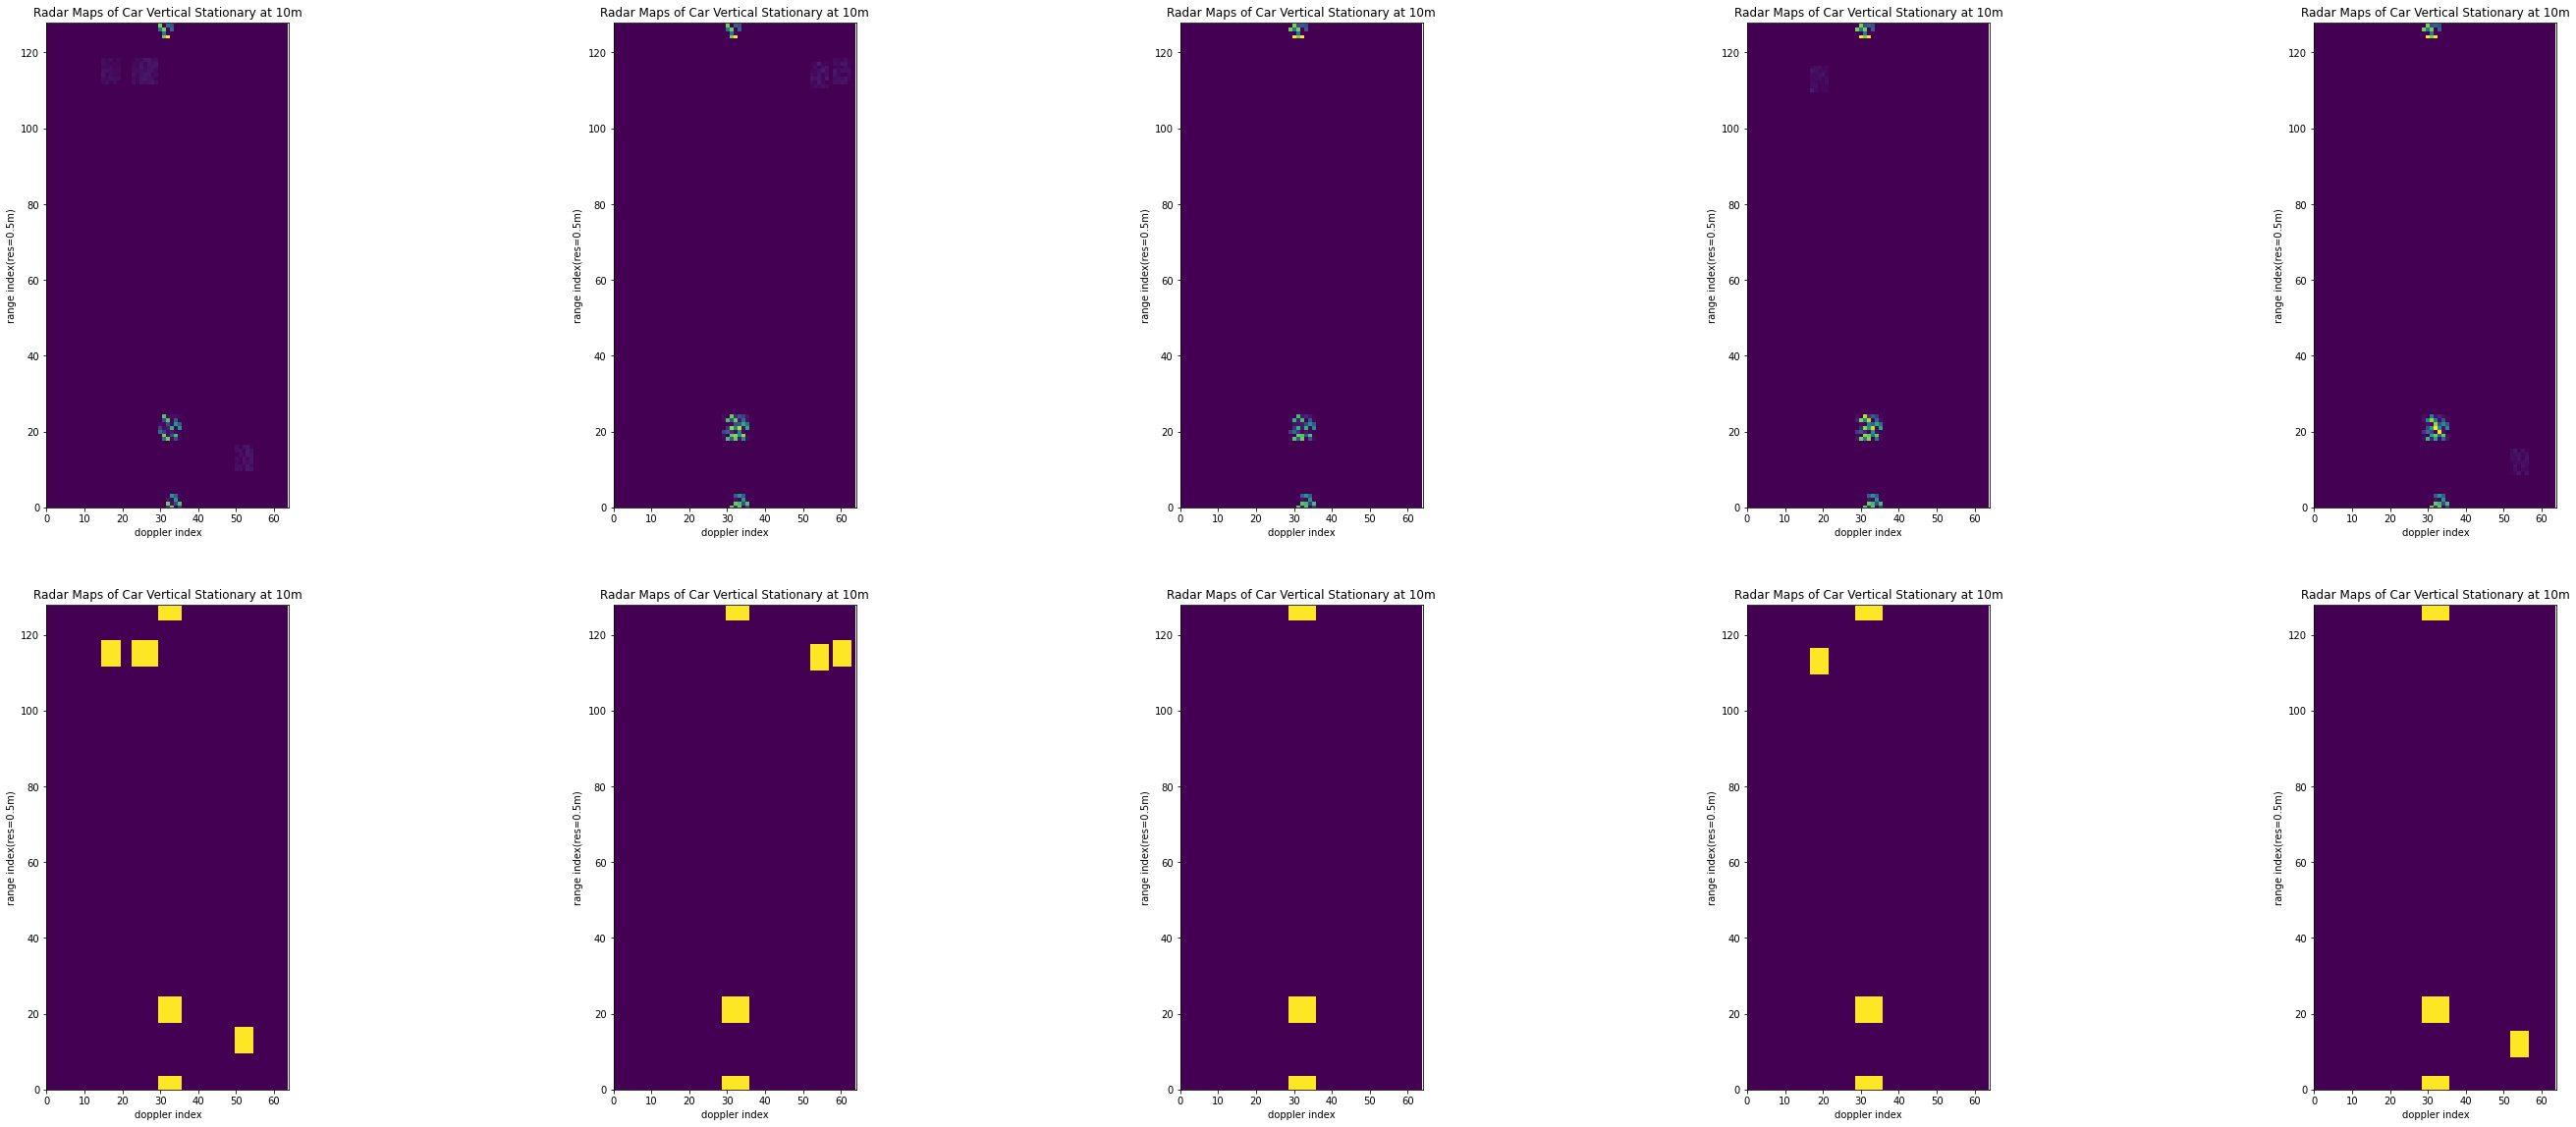

In [52]:
plotArrays(arrCarVday1_10, labelCarVday1_10, "Radar Maps of Car Vertical Stationary at 10m")

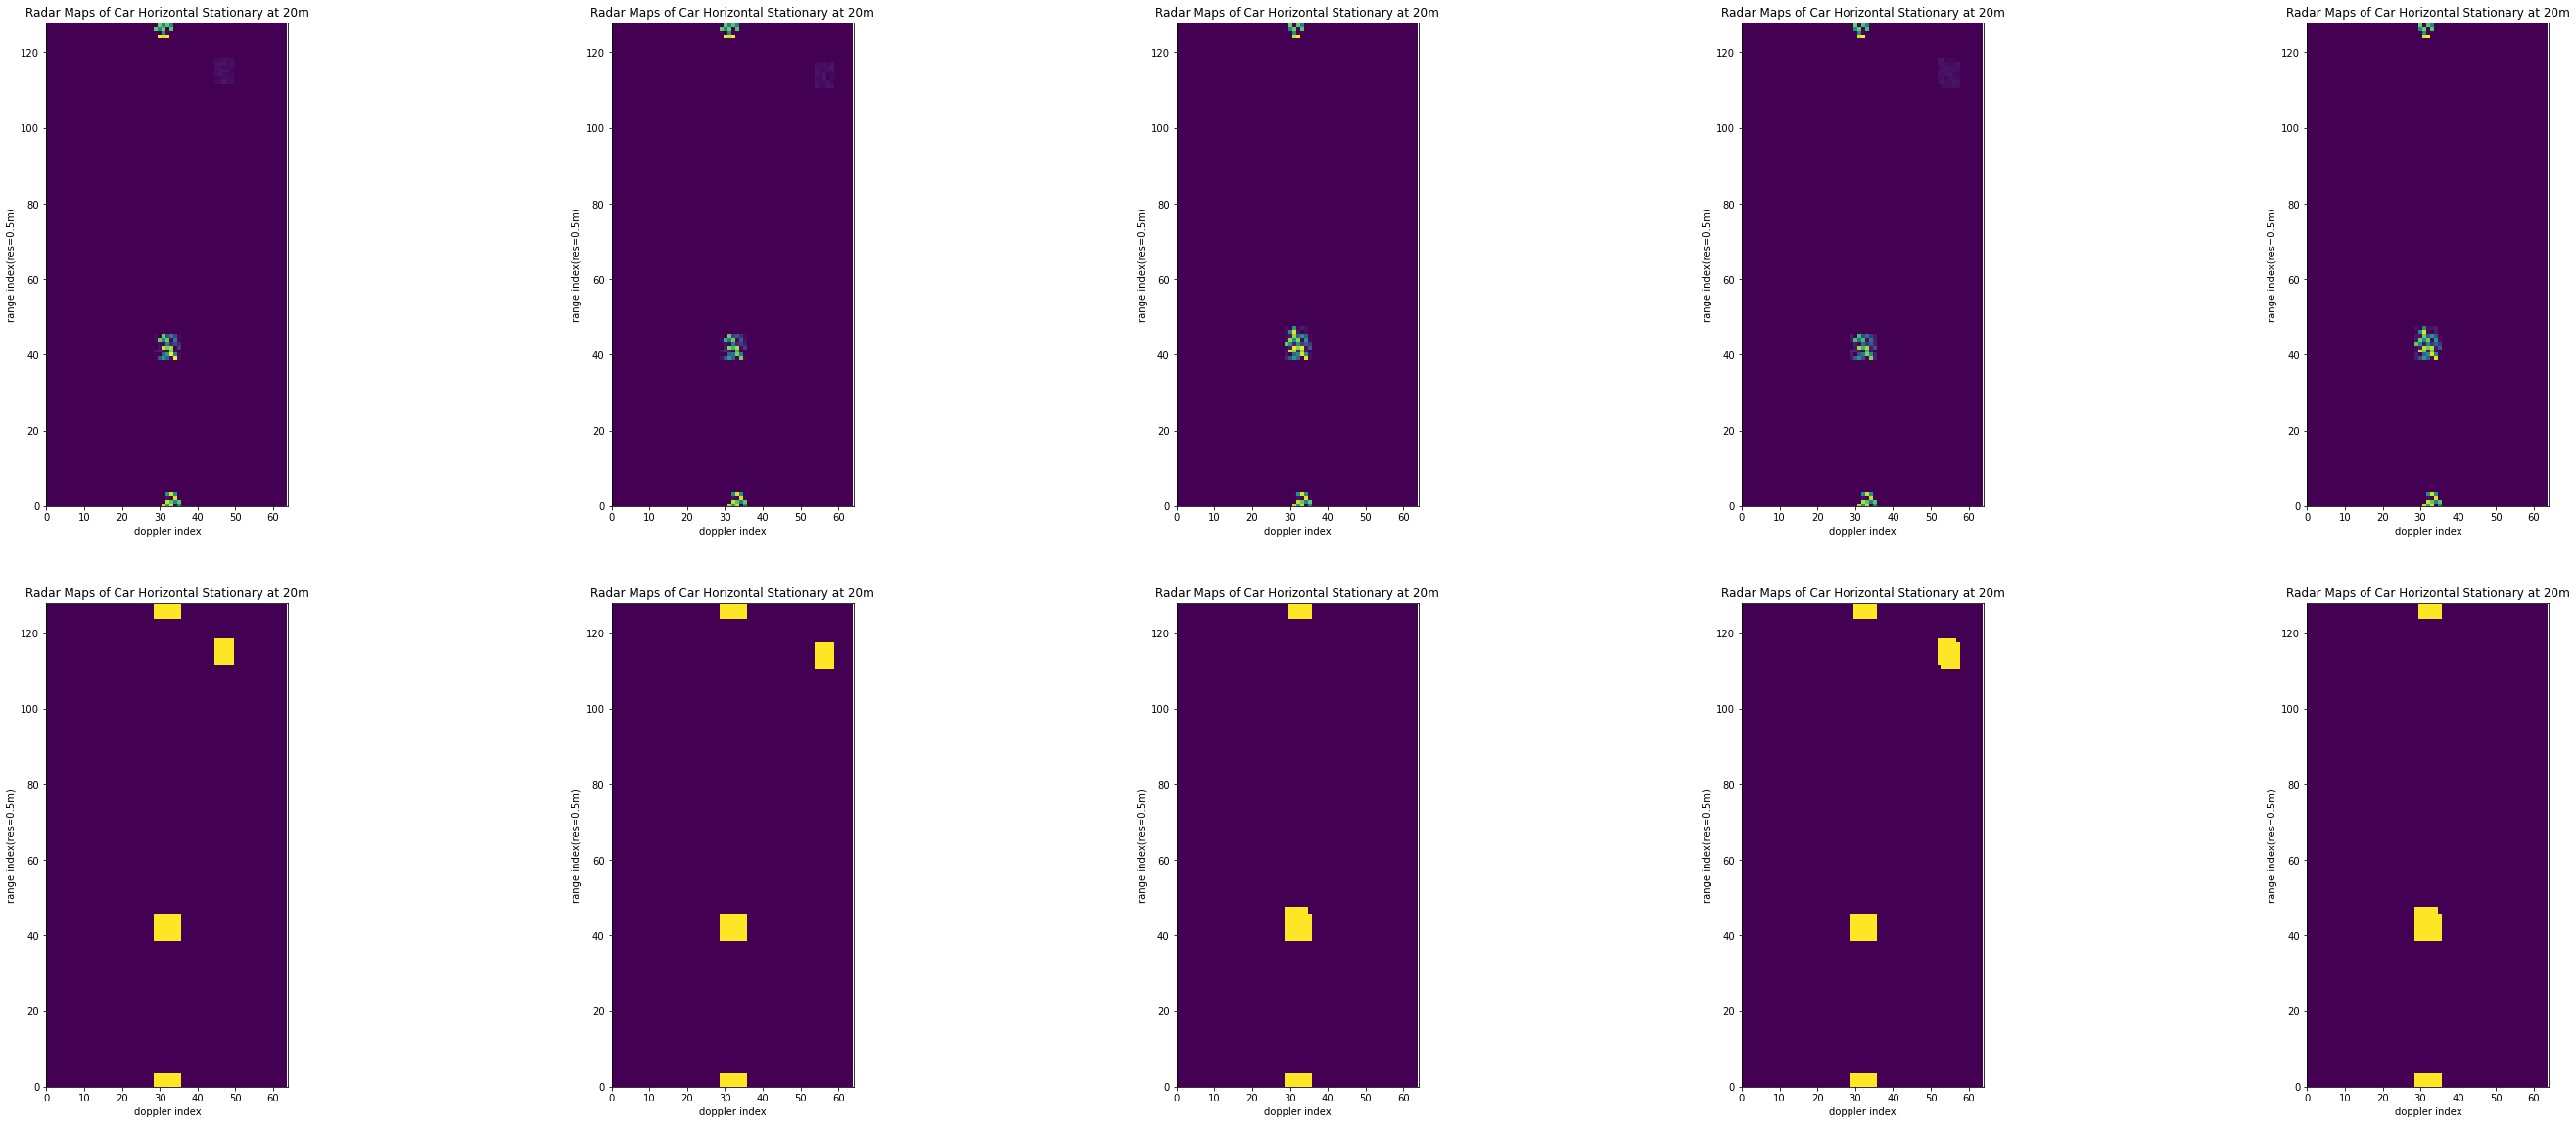

In [53]:
plotArrays(arrCarHday1_20, labelCarHday1_20, "Radar Maps of Car Horizontal Stationary at 20m")